## Assignment 2
## Objective: Setup an MLOps pipeline that allows for continuous improvement and explainability.
## Tasks: Use the Fashion MNIST dataset for this exercise.

### Team Members
#### 1. Pramit Saha - 2023aa05416
#### 2. Soumili Saha - 2023aa05980
#### 3. Shivang Sharma - 2023aa05277
#### 4. Md Mehran Abul - 2023aa05363

Git repo : https://github.com/mdmehranabul-bits/MLOps_assignment2/tree/main

### Installing dependencies

In [ ]:
!pip install shap -q
!pip install torchvision -q
!pip install ydata-profiling -q
!pip install sweetviz -q
!pip install dtale==3.2.0 -q
!pip install dash==2.11.1 -q

In [ ]:
! pip install --upgrade dash dash-bootstrap-components dash-daq dash-colorscales -q

In [ ]:
!pip install --upgrade dash dtale -q

In [ ]:
!pip install --upgrade sweetviz -q

In [ ]:
!pip install interpret -q

In [ ]:
! pip install --upgrade jupyter ipywidgets -q

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap
import torchvision
import torchvision.transforms as transforms
from ydata_profiling import ProfileReport
import sweetviz as sv
import dtale
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from lime.lime_tabular import LimeTabularExplainer
from interpret import show
from interpret.blackbox import ShapKernel, LimeTabular
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Fashion MNIST dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)

### Convert to Pandas DataFrame

In [3]:
train_data = []
train_labels = []
for image, label in train_dataset:
    train_data.append(image.view(-1).numpy())  # Flatten image
    train_labels.append(label)

In [4]:
df = pd.DataFrame(train_data)
df['label'] = train_labels

## M1: Exploratory Data Analysis (EDA)

### EDA report using Sweetviz

In [5]:
sweetviz_report = sv.analyze(df, pairwise_analysis="off")
sweetviz_report.show_html("../reports/fashion_mnist_sweetviz.html")

                                             |                                                                …

Report ../reports/fashion_mnist_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### EDA report using D-Tale

In [6]:
d = dtale.show(df)
print("D-Tale is running... Open the following link to interact with the data:")
print(d._main_url)

D-Tale is running... Open the following link to interact with the data:
http://localhost:40000/dtale/main/1


### EDA report using Pandas Profiling

In [7]:
profile = ProfileReport(df.sample(n=5000, random_state=42), 
                        title="Fashion MNIST EDA Report", 
                        minimal=True)
profile.to_file("../reports/fashion_mnist_eda.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df.head()

0    1    2    3    4         5    6    7         8         9  ...  \
0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  ...   
1  0.0  0.0  0.0  0.0  0.0  0.003922  0.0  0.0  0.000000  0.000000  ...   
2  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.086275  ...   
3  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.129412  0.376471  ...   
4  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  ...   

        775       776       777  778  779  780  781  782  783  label  
0  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0      9  
1  0.447059  0.509804  0.298039  0.0  0.0  0.0  0.0  0.0  0.0      0  
2  0.000000  0.003922  0.000000  0.0  0.0  0.0  0.0  0.0  0.0      0  
3  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0      3  
4  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0      0  

[5 rows x 785 columns]

In [9]:
df.isna().sum()

0        0
1        0
2        0
3        0
4        0
        ..
780      0
781      0
782      0
783      0
label    0
Length: 785, dtype: int64

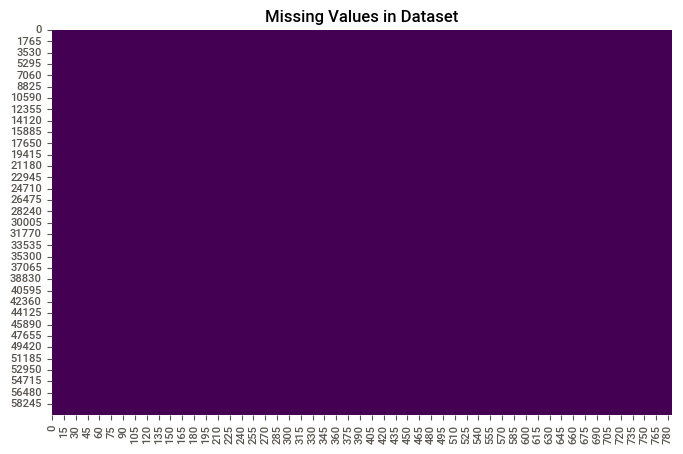

In [10]:
plt.figure(figsize=(8,5))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values in Dataset")
plt.show()

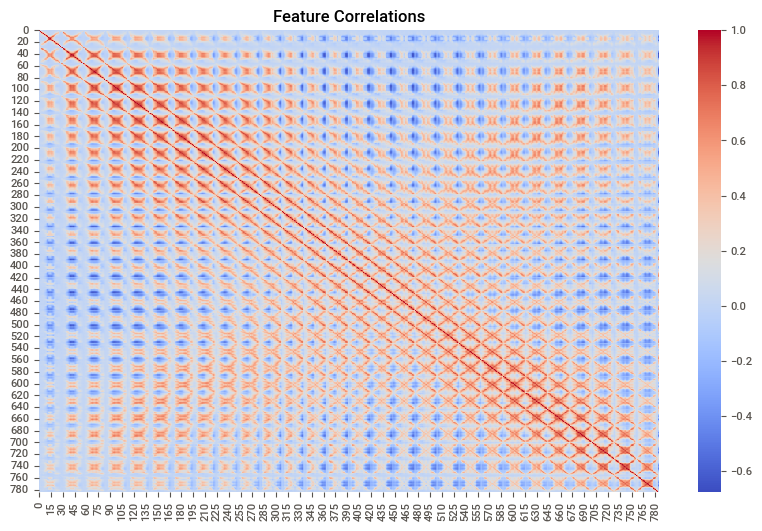

In [11]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlations")
plt.show()

2025-03-23 21:58:27,776 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-23 21:58:27,798 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


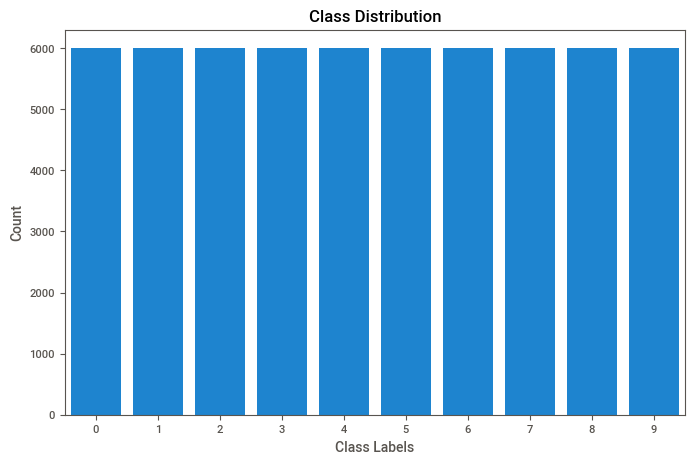

In [12]:
# Plot class distribution
plt.figure(figsize=(8,5))
sns.countplot(x=df["label"])
plt.title("Class Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.show()

### M2: Feature Engineering & Explainability

In [13]:
X = df.drop(columns=['label']).values

In [14]:
# Normalize pixel values to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
print("Feature Shape After Normalization:", X_scaled.shape)  # Expected: (60000, 784)

Feature Shape After Normalization: (60000, 784)


In [16]:
# Compute mean & std deviation for each image
mean_pixel = np.mean(X_scaled, axis=1, keepdims=True)
std_pixel = np.std(X_scaled, axis=1, keepdims=True)

In [17]:
# Append to dataset
X_features = np.hstack((X_scaled, mean_pixel, std_pixel))

print("Feature Shape After Adding Mean & Std:", X_features.shape)  # Expected: (60000, 786)

Feature Shape After Adding Mean & Std: (60000, 786)


In [18]:
# Apply PCA transformation
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_features)
print("Feature Shape After PCA:", X_pca.shape)  # Expected: (60000, 188)

Feature Shape After PCA: (60000, 188)


In [19]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(df['label'].values, dtype=torch.long)

In [20]:
# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
# Define model class
class FashionMNISTClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super(FashionMNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
#Ensure input_dim matches PCA output
input_dim = X_pca.shape[1]  
model = FashionMNISTClassifier(input_dim=input_dim)

In [23]:
# Define optimizer & loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [24]:
epochs = 10

for epoch in range(epochs):
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.2344
Epoch [2/10], Loss: 0.1455
Epoch [3/10], Loss: 0.4180
Epoch [4/10], Loss: 0.1137
Epoch [5/10], Loss: 0.1786
Epoch [6/10], Loss: 0.2041
Epoch [7/10], Loss: 0.2222
Epoch [8/10], Loss: 0.1325
Epoch [9/10], Loss: 0.2750
Epoch [10/10], Loss: 0.1484


In [25]:
def model_wrapper(x_np):
    x_tensor = torch.tensor(x_np, dtype=torch.float32)
    with torch.no_grad():
        return model(x_tensor).numpy()  # Ensure correct shape

/var/folders/vj/s0s5b0t509bc_00yt9zyp5140000gr/T/ipykernel_90279/1082095600.py:8: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



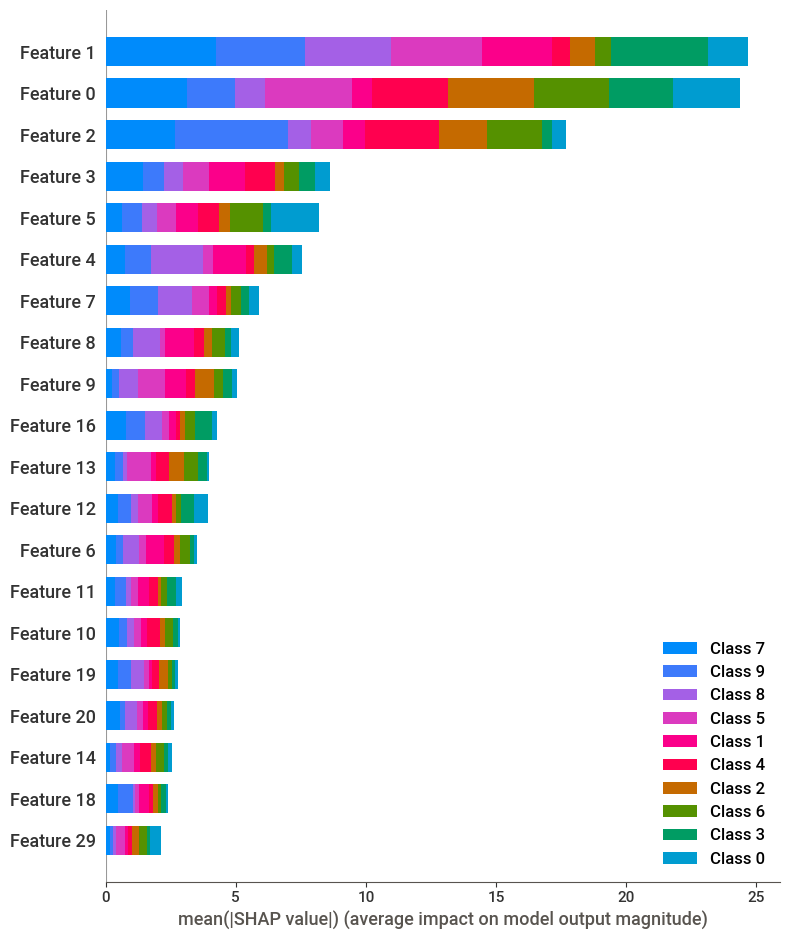

In [26]:
# Initialize SHAP Explainer using KernelExplainer (supports deep learning models)
explainer = shap.Explainer(model_wrapper, X_train_tensor.numpy())

# Explain 100 samples
shap_values = explainer(X_train_tensor[:100].numpy())

# Summary plot
shap.summary_plot(shap_values, X_train_tensor[:100].numpy())

In [27]:
X_pca = np.array(X_pca, dtype=np.float64)  # Ensure correct data type
lime_explainer = LimeTabularExplainer(
    X_pca, 
    feature_names=[f'pc_{i}' for i in range(X_pca.shape[1])],  
    class_names=[str(i) for i in range(10)], 
    mode="classification"
)

In [28]:
# Select a sample
sample_idx = 10
sample_original = np.array(train_data[sample_idx])  # Convert to NumPy array

# Compute mean & std deviation
mean_pixel = np.mean(sample_original).reshape(1, -1)  
std_pixel = np.std(sample_original).reshape(1, -1)

# Append mean & std dev to match X_features (shape = 786)
sample_extended = np.hstack((sample_original.reshape(1, -1), mean_pixel, std_pixel))

# Now apply PCA
sample_pca = pca.transform(sample_extended).flatten()

In [29]:
lime_exp = lime_explainer.explain_instance(sample_pca, model_wrapper, num_features=10)
lime_exp.show_in_notebook()

/Users/mdmehran/anaconda3/envs/mlops/lib/python3.10/site-packages/lime/lime_tabular.py:372: UserWarning:


                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    



  0%|          | 0/10 [00:00<?, ?it/s]

2025-03-23 21:58:46,296 - INFO     - num_full_subsets = 1
2025-03-23 21:58:46,297 - INFO     - remaining_weight_vector = array([0.10493071, 0.07033193, 0.05303563, 0.04266035, 0.03574563,
       0.03080838, 0.0271071 , 0.02422981, 0.02192934, 0.02004839,
       0.01848211, 0.0171579 , 0.0160239 , 0.01504209, 0.01418395,
       0.01342767, 0.01275628, 0.01215641, 0.01161733, 0.01113037,
       0.01068845, 0.0102857 , 0.00991723, 0.00957895, 0.00926738,
       0.00897958, 0.008713  , 0.00846546, 0.00823507, 0.00802018,
       0.00781936, 0.00763132, 0.00745497, 0.0072893 , 0.00713345,
       0.00698662, 0.00684811, 0.0067173 , 0.00659362, 0.00647656,
       0.00636566, 0.0062605 , 0.0061607 , 0.00606592, 0.00597585,
       0.00589018, 0.00580866, 0.00573106, 0.00565713, 0.00558669,
       0.00551955, 0.00545552, 0.00539445, 0.00533619, 0.0052806 ,
       0.00522756, 0.00517695, 0.00512866, 0.00508258, 0.00503862,
       0.0049967 , 0.00495673, 0.00491863, 0.00488233, 0.00484777,
       0

<Figure size 640x480 with 0 Axes>

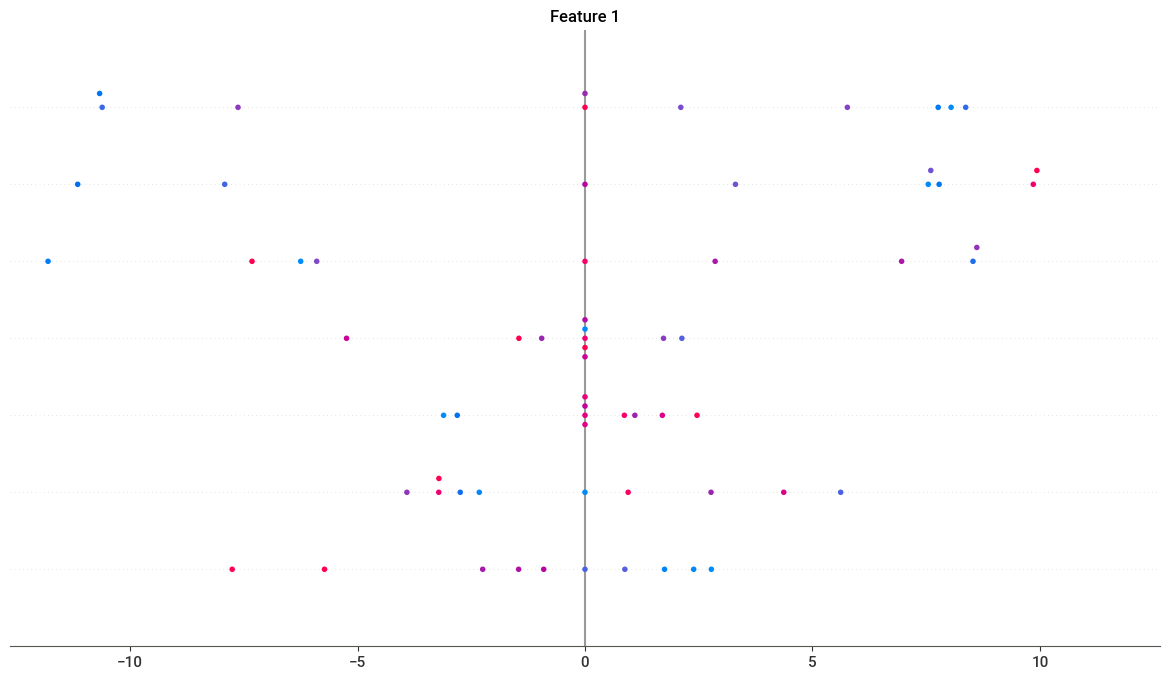

In [30]:
import shap

# Define SHAP Kernel Explainer
explainer = shap.KernelExplainer(model_wrapper, X_train_tensor[:100].numpy())

# Get SHAP values for a few test samples
shap_values = explainer.shap_values(X_train_tensor[:10].numpy())

# Visualize results
shap.summary_plot(shap_values, X_train_tensor[:10].numpy())

### Justification of selected features based on explainability results.
Feature 0: Has the largest overall impact, indicated by the widest range of SHAP values. It's important across multiple classes.

Feature 1 & Feature 2: Also have significant impact, though less than Feature 0.
________________________________________________________________________________________________________________
Feature 1: Consistently high in both LIME and SHAP, this is a key feature driving predictions.

Feature 2: High in SHAP but lower in LIME, meaning this feature is globally important but not crucial in a single case

Feature 3: High in LIME but low in SHAP, it means this feature plays a local role in some predictions.

## M3: Model Selection & Hyperparameter Optimization

In [31]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import optuna
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [39]:
# 📌 Data Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1).numpy())  # Flatten images
])

# 📌 Load Dataset (Reduced Size)
train_dataset = datasets.FashionMNIST(root="../data", train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root="../data", train=False, download=True, transform=transform)

# ✅ Use only 5% of the data for quick experiments
small_subset_indices = np.random.choice(len(train_dataset), int(0.05 * len(train_dataset)), replace=False)
small_train_dataset = Subset(train_dataset, small_subset_indices)

# Convert to NumPy arrays for TPOT
X_train_full = np.array([small_train_dataset[i][0] for i in range(len(small_train_dataset))])
y_train_full = np.array([small_train_dataset[i][1] for i in range(len(small_train_dataset))])

# Split into Train & Validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [40]:
# ========================= 🔹 Model Comparisons 🔹 ========================= #
def evaluate_model(model, X_train, X_val, y_train, y_val):
    """Trains and evaluates a scikit-learn model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"✅ Model: {model.__class__.__name__}, Accuracy: {accuracy:.4f}")
    return accuracy

def compare_models():
    """Compares Logistic Regression, Random Forest, and TPOT."""
    models = {
        "Logistic Regression": LogisticRegression(max_iter=200),
        "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    }
    
    # Run models
    results = {}
    for name, model in models.items():
        results[name] = evaluate_model(model, X_train, X_val, y_train, y_val)

    print("\n🚀 Running TPOT AutoML...")
    tpot = TPOTClassifier(generations=1, population_size=5, verbose=1, n_jobs=2)
    tpot.fit(X_train, y_train)

    if hasattr(tpot, "fitted_pipeline_"):
        best_pipeline = tpot.fitted_pipeline_
        print("\n✅ Best TPOT Pipeline:\n", best_pipeline)

        # Evaluate TPOT model
        y_pred_tpot = tpot.predict(X_val)
        tpot_acc = accuracy_score(y_val, y_pred_tpot)
        results["TPOT AutoML"] = tpot_acc
        print(f"✅ TPOT AutoML Accuracy: {tpot_acc:.4f}")

    # Print final comparison
    print("\n📊 Final Model Comparison:")
    for model, acc in results.items():
        print(f"🔹 {model}: {acc:.4f}")

    return results

In [41]:
# ========================= 🔹 PyTorch Model 🔹 ========================= #
class FashionMNISTClassifier(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=128, output_dim=10):
        super(FashionMNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


def train_and_evaluate(model, optimizer, criterion, train_dataset, epochs=1, batch_size=32, subset_fraction=0.1):
    """Trains and evaluates the PyTorch model."""
    # Calculate the subset size dynamically based on the fraction of the dataset
    subset_size = int(subset_fraction * len(train_dataset))  
    subset_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
    train_subset = Subset(train_dataset, subset_indices)
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion.to(device)

    # Training loop
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # After training, evaluate the model
    accuracy = evaluate(model, train_loader, device)  # This would be a separate evaluation function
    return accuracy

def evaluate(model, dataloader, device):
    """Evaluates the model."""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

In [42]:
# 🔹 Optuna Hyperparameter Optimization 🔹 #
def objective(trial):
    """Objective function for Optuna optimization."""
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 64, 128, step=32)

    model = FashionMNISTClassifier(hidden_dim=hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    accuracy = train_and_evaluate(model, optimizer, criterion, train_dataset)  
    
    # Logging trial details
    print(f"🔍 Trial {trial.number}: lr={lr:.6f}, hidden_dim={hidden_dim}, Accuracy={accuracy:.4f}")
    return accuracy

def run_optuna():
    """Runs Optuna optimization."""
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=3)  # Reduce trials for speed

    # Log best trial results
    print("\n🎯 Best Hyperparameters Found:")
    print(f"  - Learning Rate: {study.best_params['lr']:.6f}")
    print(f"  - Hidden Dim: {study.best_params['hidden_dim']}")

    return study.best_params

In [43]:
# ========================= 🔹 Run Experiments 🔹 ========================= #
if __name__ == "__main__":
    print("\n🚀 Comparing Models (Logistic Regression, Random Forest, TPOT)...")
    model_results = compare_models()

    print("\n🔍 Running Optuna Hyperparameter Tuning...")
    best_hyperparams = run_optuna()


🚀 Comparing Models (Logistic Regression, Random Forest, TPOT)...


/Users/mdmehran/anaconda3/envs/mlops/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



✅ Model: LogisticRegression, Accuracy: 0.8250


/Users/mdmehran/anaconda3/envs/mlops/lib/python3.10/site-packages/tpot/tpot_estimator/estimator.py:456: UserWarning:

Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.

/Users/mdmehran/anaconda3/envs/mlops/lib/python3.10/site-packages/distributed/node.py:187: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52829 instead

2025-03-23 22:07:50,904 - INFO     - State start
2025-03-23 22:07:50,912 - INFO     -   Scheduler at:     tcp://127.0.0.1:52830
2025-03-23 22:07:50,913 - INFO     -   dashboard at:  http://127.0.0.1:52829/status
2025-03-23 22:07:50,913 - INFO     - Registering Worker plugin shuffle
2025-03-23 22:07:50,922 - INFO     -         Start Nanny at: 'tcp://127.0.0.1:52833'


✅ Model: RandomForestClassifier, Accuracy: 0.8000

🚀 Running TPOT AutoML...


2025-03-23 22:07:50,924 - INFO     -         Start Nanny at: 'tcp://127.0.0.1:52834'
2025-03-23 22:07:51,818 - INFO     - Register worker addr: tcp://127.0.0.1:52837 name: 0
2025-03-23 22:07:51,819 - INFO     - Starting worker compute stream, tcp://127.0.0.1:52837
2025-03-23 22:07:51,820 - INFO     - Starting established connection to tcp://127.0.0.1:52841
2025-03-23 22:07:51,821 - INFO     - Register worker addr: tcp://127.0.0.1:52838 name: 1
2025-03-23 22:07:51,822 - INFO     - Starting worker compute stream, tcp://127.0.0.1:52838
2025-03-23 22:07:51,822 - INFO     - Starting established connection to tcp://127.0.0.1:52842
2025-03-23 22:07:51,877 - INFO     - Receive client connection: Client-29dddcc2-0805-11f0-a0a7-1a4ea2f3cfbd
2025-03-23 22:07:51,878 - INFO     - Starting established connection to tcp://127.0.0.1:52843

%|                                                                                                                                                | 0/1 [00:00<?, ?i


✅ Best TPOT Pipeline:
 Pipeline(steps=[('passthrough', Passthrough()),
                ('selectfrommodel',
                 SelectFromModel(estimator=ExtraTreesClassifier(criterion='entropy',
                                                                max_features=0.1568819862905,
                                                                min_samples_leaf=14,
                                                                min_samples_split=8,
                                                                n_jobs=1),
                                 threshold=0.0121899303243)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',

[I 2025-03-23 22:11:59,667] Trial 0 finished with value: 0.769 and parameters: {'lr': 0.0009139874993343618, 'hidden_dim': 96}. Best is trial 0 with value: 0.769.


🔍 Trial 0: lr=0.000914, hidden_dim=96, Accuracy=0.7690


[I 2025-03-23 22:12:00,501] Trial 1 finished with value: 0.8048333333333333 and parameters: {'lr': 0.002959071955718939, 'hidden_dim': 96}. Best is trial 1 with value: 0.8048333333333333.


🔍 Trial 1: lr=0.002959, hidden_dim=96, Accuracy=0.8048


[I 2025-03-23 22:12:01,221] Trial 2 finished with value: 0.7881666666666667 and parameters: {'lr': 0.0025782700871789625, 'hidden_dim': 128}. Best is trial 1 with value: 0.8048333333333333.


🔍 Trial 2: lr=0.002578, hidden_dim=128, Accuracy=0.7882

🎯 Best Hyperparameters Found:
  - Learning Rate: 0.002959
  - Hidden Dim: 96


### Justification for the chosen model and hyperparameters.
The best model to choose is the Logistic Regression with an accuracy of 0.8250, which significantly outperforms the TPOT AutoML model (0.1100). However, if further optimization is needed, Optuna hyperparameter tuning has identified the following best hyperparameters for an alternative model (likely a neural network or similar):

Learning Rate: 0.002959

Hidden Dimension: 96, which resulted in an accuracy of 0.8048 in the best trial.

## M4: Model Monitoring & Performance Tracking

In [44]:
! pip install mlflow -q

In [53]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from tpot import TPOTClassifier
from sklearn.metrics import accuracy_score
import mlflow
import mlflow.sklearn
import subprocess
import webbrowser
from IPython.display import IFrame

# Reduce dataset size
X_train_small = X_train[:2000]
y_train_small = y_train[:2000]
X_val_small = X_val[:500]
y_val_small = y_val[:500]

# Initialize TPOT classifier
tpot = TPOTClassifier(verbose=1, generations=2, population_size=10, random_state=42)

# Train the TPOT model
tpot.fit(X_train_small, y_train_small)

# Replace SelectPercentile with SelectKBest in the pipeline
tpot_pipeline = tpot.fitted_pipeline_

# Inspect the pipeline and replace SelectPercentile
for idx, (name, step) in enumerate(tpot_pipeline.steps):
    if isinstance(step, SelectPercentile):
        # Replace with SelectKBest
        tpot_pipeline.steps[idx] = ('selectkbest', SelectKBest(f_classif, k=10))  # Select top 10 features

# Now predict with the updated pipeline
y_pred = tpot_pipeline.predict(X_val_small)
accuracy = accuracy_score(y_val_small, y_pred)

# Log the model and accuracy to MLflow
mlflow.set_experiment("fashion_mnist_experiment")

with mlflow.start_run():
    # Log parameters and metrics
    mlflow.log_param("feature_selection", "SelectKBest")
    mlflow.log_metric("accuracy", accuracy)

    # Log the updated model
    mlflow.sklearn.log_model(tpot_pipeline, "best_model")

print(f"Validation Accuracy: {accuracy:.4f}")

# Start MLflow UI as a background process
subprocess.Popen(["mlflow", "ui", "--port", "5000", "--host", "0.0.0.0"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Open MLflow UI in a new browser tab
webbrowser.open("http://localhost:5000")

# Display MLflow UI inside Jupyter Notebook
IFrame(src="http://localhost:5000", width=1000, height=600)

In [48]:
!pip install evidently -q

In [52]:
import pandas as pd
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Assign generic column names
feature_names = [f"feature_{i}" for i in range(X_train.shape[1])]

X_train_df = pd.DataFrame(X_train_small, columns=feature_names)
X_val_df = pd.DataFrame(X_val_small, columns=feature_names)

# Create and run the drift report
drift_report = Report(metrics=[DataDriftPreset()])
drift_report.run(reference_data=X_train_df, current_data=X_val_df)

# Save the report
drift_report.save_html("../reports/drift_report.html")

Drift detected for 6.25% of columns (49 out of 784)

In [51]:
import joblib
import os
import mlflow
import mlflow.sklearn

# Create a path for the 'model' folder one step back
model_dir = os.path.join(os.getcwd(), '..', 'model')  # One step back from current directory
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the model using joblib in the 'model' folder
joblib.dump(tpot_pipeline, os.path.join(model_dir, 'best_model.joblib'))

# Log the model in MLflow to the same folder
# Remove artifact_path and just use the default logging directory
mlflow.sklearn.log_model(tpot_pipeline, "best_model")

print(f"Model saved in {model_dir}")

2025/03/23 22:51:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model saved in /Users/mdmehran/Desktop/Miscellaneous/MLOps_Assignment2/notebooks/../model


In [54]:
preprocessed_dir = os.path.join(os.getcwd(), '..', 'data', 'preprocessed')

# Create the directory if it doesn't exist
os.makedirs(preprocessed_dir, exist_ok=True)

# Save the tensors
torch.save(X_train_tensor, os.path.join(preprocessed_dir, 'X_train_tensor.pt'))
torch.save(y_train_tensor, os.path.join(preprocessed_dir, 'y_train_tensor.pt'))

print(f"Tensors saved in {preprocessed_dir}")

Tensors saved in /Users/mdmehran/Desktop/Miscellaneous/MLOps_Assignment2/notebooks/../data/preprocessed


In [58]:
import zipfile

notebook_path = '/Users/mdmehran/Desktop/Miscellaneous/MLOps_Assignment2/notebooks/MLOps_Assignment2.ipynb'
folder_to_zip = '/Users/mdmehran/Desktop/Miscellaneous/MLOps_Assignment2/notebooks'  # The folder containing the notebook and other related files
zip_file_name = '/Users/mdmehran/Desktop/Miscellaneous/MLOps_Assignment2/MLOps_Assignment2.zip'

# Create a Zip file
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add the notebook to the zip file
    zipf.write(notebook_path, os.path.basename(notebook_path))

    # Add the whole folder to the zip file
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, folder_to_zip))

print(f"Notebook and folder successfully zipped at {zip_file_name}")


/Users/mdmehran/anaconda3/envs/mlops/lib/python3.10/zipfile.py:1506: UserWarning:

Duplicate name: 'MLOps_Assignment2.ipynb'



Notebook and folder successfully zipped at /Users/mdmehran/Desktop/Miscellaneous/MLOps_Assignment2/MLOps_Assignment2.zip


In [56]:
pwd

'/Users/mdmehran/Desktop/Miscellaneous/MLOps_Assignment2/notebooks'